# InfluxDB EDA Notebook
Read data from InfluxDB and perform quick exploratory analysis.

## 1. Install and Import Dependencies
Install the InfluxDB client and import libraries used for analysis.

In [2]:
# If needed, uncomment the next line to install dependencies
%pip install influxdb-client pandas matplotlib

from influxdb_client import InfluxDBClient
import pandas as pd
import matplotlib.pyplot as plt

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------------------------------ --------- 6.3/8.1 MB 29.7 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 29.7 MB/s  0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 26.5 MB/s  0:00:00

   ---------------------------------------- 0/6 [pyparsing]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------

## 2. Configure InfluxDB Connection
Load connection settings and create a client.

In [3]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent))

from src.app.config import INFLUX_URL, INFLUX_TOKEN, INFLUX_ORG, INFLUX_BUCKET

client = InfluxDBClient(url=INFLUX_URL, token=INFLUX_TOKEN, org=INFLUX_ORG)
query_api = client.query_api()

print("Connected to InfluxDB:", INFLUX_URL)
print("Bucket:", INFLUX_BUCKET)

Connected to InfluxDB: http://localhost:8086
Bucket: sensor_data


## 3. Build Flux Queries
Compose Flux queries for counts, time range, and a sample dataset.

In [4]:
time_start = "2004-02-28T00:00:00Z"
time_stop = "2004-03-29T23:59:59Z"

count_query = f'''
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: {time_start}, stop: {time_stop})
  |> filter(fn: (r) => r._measurement == "sensor_reading")
  |> count()
'''

range_query = f'''
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: {time_start}, stop: {time_stop})
  |> filter(fn: (r) => r._measurement == "sensor_reading")
  |> first()
'''

sample_query = f'''
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: {time_start}, stop: {time_stop})
  |> filter(fn: (r) => r._measurement == "sensor_reading")
  |> limit(n: 5000)
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
'''

count_query

'\nfrom(bucket: "sensor_data")\n  |> range(start: 2004-02-28T00:00:00Z, stop: 2004-03-29T23:59:59Z)\n  |> filter(fn: (r) => r._measurement == "sensor_reading")\n  |> count()\n'

## 4. Read Data into a DataFrame
Run the sample query and load the results into pandas.

In [5]:
df = query_api.query_data_frame(sample_query)

# query_data_frame can return a list of dataframes
if isinstance(df, list):
    df = pd.concat(df, ignore_index=True)

# Basic cleanup
if not df.empty:
    df["_time"] = pd.to_datetime(df["_time"])
    df = df.sort_values("_time")

print("Rows:", len(df))
df.head()

Rows: 262368


,result,table,_start,_stop,_time,_measurement,mote_id,humidity,light,temperature,voltage
47337,_result,10,2004-02-28 00:00:00+00:00,2004-03-29 23:59:59+00:00,2004-02-28 00:58:46.002832+00:00,sensor_reading,19,37.0933,71.76000,19.7336,2.69964
82337,_result,17,2004-02-28 00:00:00+00:00,2004-03-29 23:59:59+00:00,2004-02-28 00:58:46.171824+00:00,sensor_reading,25,37.5737,97.52000,19.6160,2.69964
77337,_result,16,2004-02-28 00:00:00+00:00,2004-03-29 23:59:59+00:00,2004-02-28 00:58:46.206631+00:00,sensor_reading,24,37.1620,143.52000,19.7728,2.71196
107337,_result,22,2004-02-28 00:00:00+00:00,2004-03-29 23:59:59+00:00,2004-02-28 00:58:46.497331+00:00,sensor_reading,3,36.8871,50.60000,20.2040,2.69964
97337,_result,20,2004-02-28 00:00:00+00:00,2004-03-29 23:59:59+00:00,2004-02-28 00:58:46.504403+00:00,sensor_reading,28,40.0945,2.80151,19.0476,2.68742


## 5. Validate and Preview Results
Check columns, basic stats, and a quick plot.

,_time,mote_id,temperature,humidity,light,voltage
47337,2004-02-28 00:58:46.002832+00:00,19,19.7336,37.0933,71.76000,2.69964
82337,2004-02-28 00:58:46.171824+00:00,25,19.6160,37.5737,97.52000,2.69964
77337,2004-02-28 00:58:46.206631+00:00,24,19.7728,37.1620,143.52000,2.71196
107337,2004-02-28 00:58:46.497331+00:00,3,20.2040,36.8871,50.60000,2.69964
97337,2004-02-28 00:58:46.504403+00:00,28,19.0476,40.0945,2.80151,2.68742


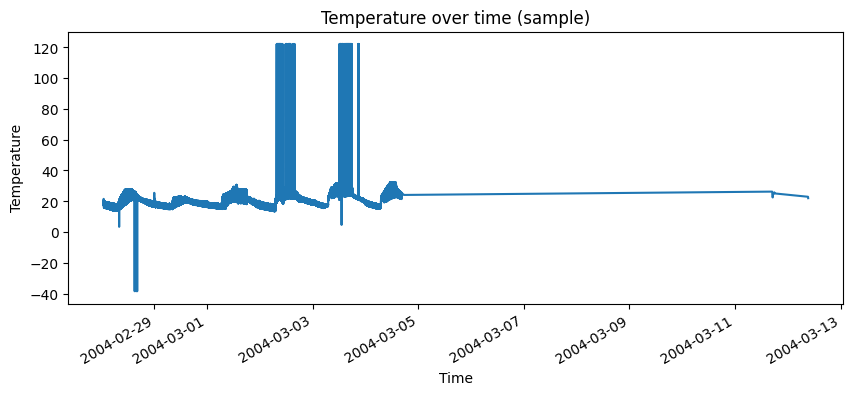

In [6]:
df.columns

if not df.empty:
    display(df[["_time", "mote_id", "temperature", "humidity", "light", "voltage"]].head())

# Simple visualization
if not df.empty:
    ax = df.plot(x="_time", y="temperature", figsize=(10, 4), legend=False)
    ax.set_title("Temperature over time (sample)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature")
    plt.show()

## 6. Handle Errors and Retries
Add basic retry logic for transient query failures.

In [7]:
import time


def run_with_retry(query: str, retries: int = 3, delay_seconds: int = 5):
    last_error = None
    for attempt in range(1, retries + 1):
        try:
            return query_api.query(query)
        except Exception as exc:
            last_error = exc
            print(f"Attempt {attempt} failed: {exc}")
            time.sleep(delay_seconds)
    raise last_error

# Example: retry count query
try:
    result = run_with_retry(count_query, retries=2, delay_seconds=3)
    total = sum(record.get_value() for table in result for record in table.records)
    print("Total points:", total)
except Exception as exc:
    print("Query failed after retries:", exc)

Total points: 8668836


## **EDA Checklist**

1. **Data volume & coverage**
   - Total points, time range, sampling density

2. **Schema validation**
   - Check fields: temperature, humidity, light, voltage  
   - Confirm tags: mote_id

3. **Missing values & gaps**
   - % missing per field  
   - Identify time gaps per mote

4. **Basic statistics**
   - Mean, median, min, max, std for each field

5. **Time-series trends**
   - Plot each field over time (overall + per mote)

6. **Seasonality & cycles**
   - Daily/weekly patterns (if present)

7. **Distribution analysis**
   - Histograms + boxplots per field  
   - Outlier detection

8. **Correlation analysis**
   - Correlation between temperature, humidity, light, voltage

9. **Mote-level comparisons**
   - Compare averages across motes  
   - Detect anomalous motes

10. **Data quality checks**
    - Negative/invalid values  
    - Voltage drop anomalies  
    - Sudden spikes

11. **Aggregation views**
    - Hourly/daily aggregates  
    - Heatmaps by time and mote

12. **Sampling validation**
    - Confirm expected data density per mote over time
